## DL test
Quick deep learning approach test with fastAI.

In [1]:
from fastai.tabular import * 
from sklearn import preprocessing

In [2]:
df = pd.read_csv('../data/train.csv', '|')
df.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


Subset (as in data overview)

In [ ]:
fraudulent = df[df['fraud']==1]
non_fraudulent = df[df['fraud']==0]
n = fraudulent.count()[0]
non_fraudulent_subset = non_fraudulent.sample(n)
fraudulent.reset_index(drop=True, inplace=True)
non_fraudulent_subset.reset_index(drop=True, inplace=True)
dfs = pd.concat([fraudulent, non_fraudulent_subset])
dfs = dfs.sample(208).reset_index(drop=True)

Simple DL model

In [ ]:
dep_var = 'fraud'
valid_idx = range(len(dfs)-20, len(dfs))
procs = [Normalize]
data = TabularDataBunch.from_df(path='data', df=dfs, procs=procs, dep_var=dep_var, valid_idx=valid_idx)

In [ ]:
data

In [ ]:
del learn

In [ ]:
learn = tabular_learner(data, layers=[200, 100], metrics=accuracy)
learn.fit_one_cycle(3, 1e-2)

In [ ]:
learn.save('tab-1')

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learninterp = ClassificationInterpretation.from_learner(learn)
learninterp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [ ]:
dft = pd.read_csv('data/test.csv', '|')

In [ ]:
columns_names = list(dft.columns)

In [ ]:
dft.head()

In [ ]:
def normalize_columns(df, columns_names):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled, columns=columns_names)
    return df

In [ ]:
dft = normalize_columns(dft, columns_names)

In [ ]:
dft.head()

In [ ]:
fh = open('data/test_results.csv', 'w')
for i in range(len(dft)):
    try:
        fh.write(str(learn.predict(dft.iloc[i])[0]) + "\n")
    except IndexError:
        pass
fh.close()

In [ ]:
fh = open('../data/test_results.csv', 'r')
fc = 0
nfc = 0
for line in fh:
    if line.strip() == '1':
        fc += 1
    else:
        nfc += 1
fh.close()
print(fc, nfc)

In [ ]:
308/len(dft)*100

### Test with RandomOverSampling

In [4]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

X, y = df.drop('fraud', axis=1), df['fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

ro = RandomOverSampler(random_state=123)
X_res, y_res = ro.fit_resample(X_train, y_train)

In [29]:
dftrain = pd.DataFrame(data=X_res)
dftrain['fraud'] = y_res
dftrain.columns = df.columns

dftrain = dftrain.sample(frac=1).reset_index(drop=True)

dftest = pd.DataFrame(data=X_test)
dftest['fraud'] = y_test
dftest.columns = df.columns

In [55]:
dep_var = 'fraud'
valid_idx = range(len(dftrain)-600, len(dftrain))
procs = [Normalize]
data = TabularDataBunch.from_df(path='data', 
                                df=dftrain, 
                                valid_idx=valid_idx,
                                procs=procs, 
                                dep_var=dep_var)

In [56]:
learn = tabular_learner(data, layers=[200, 100], metrics=[accuracy])
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.279567,0.319458,0.838333,00:01
1,0.199145,0.145136,0.940000,00:01
2,0.153550,0.214402,0.926667,00:01
3,0.127200,0.114097,0.965000,00:01
4,0.109189,0.115611,0.953333,00:01


In [62]:
pred = []
for i in range(len(dftest)):
    pred.append(learn.predict(dftest.iloc[i])[0])

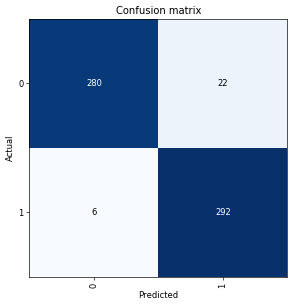

In [74]:
learninterp = ClassificationInterpretation.from_learner(learn)
learninterp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [75]:
dftest['predicted'] = pred

In [81]:
dftest[dftest['fraud'].astype(str) != dftest['predicted'].astype(str)]

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,predicted
715,1,1666,93.56,6,6,4,0.007803,0.056158,0.461538,0,1
516,1,1045,45.74,0,2,4,0.026794,0.043770,0.000000,1,0
1052,2,1796,83.98,8,9,4,0.007795,0.046759,0.571429,0,1
680,1,1506,36.67,7,3,4,0.011952,0.024349,0.388889,0,1
102,1,1319,37.10,7,7,0,0.014405,0.028127,0.368421,0,1
1478,1,46,21.96,11,4,1,0.521739,0.477391,0.458333,0,1
180,1,219,89.69,3,5,5,0.114155,0.409543,0.120000,0,1
1504,1,62,97.71,9,5,5,0.322581,1.575968,0.450000,0,1
1368,2,1300,99.59,0,9,1,0.022308,0.076608,0.000000,1,0
1284,2,1400,44.37,10,1,2,0.020000,0.031693,0.357143,1,0
